## 1. Transfer Learning for Image Classification

### (a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             classification_report, accuracy_score)
import cv2
import pandas as pd
import matplotlib.pyplot as plt

### (b) Data Exploration and Pre-processing
#### i. Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.
#### ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [2]:
LEARNING_RATE = 1e-3  
DATA_DIR = "../data/RealWaste"
IMAGE_SIZE = (224, 224)
class_names = sorted(
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
)
num_classes = len(class_names)

paths, labels = [], []
for idx, cname in enumerate(class_names):
    folder = os.path.join(DATA_DIR, cname)
    files = sorted(f for f in os.listdir(folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg')))
    for f in files:
        paths.append(os.path.join(folder, f))
        labels.append(idx)

idx_train, idx_test = train_test_split(
    np.arange(len(paths)), test_size=0.20,
    stratify=labels, random_state=42
)
train_paths = [paths[i] for i in idx_train]
train_labels = [labels[i] for i in idx_train]
test_paths  = [paths[i] for i in idx_test]
test_labels = [labels[i] for i in idx_test]

idx_train2, idx_val = train_test_split(
    np.arange(len(train_paths)), test_size=0.20,
    stratify=train_labels, random_state=42
)
X_train_paths  = [train_paths[i] for i in idx_train2]
y_train_labels = [train_labels[i] for i in idx_train2]
X_val_paths    = [train_paths[i] for i in idx_val]
y_val_labels   = [train_labels[i] for i in idx_val]

y_train = to_categorical(y_train_labels, num_classes)
y_val   = to_categorical(y_val_labels,   num_classes)
y_test  = to_categorical(test_labels,    num_classes)

def preprocess(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    return preprocess_input(img.astype("float32"))

X_train = np.array([preprocess(p) for p in X_train_paths])
X_val   = np.array([preprocess(p) for p in X_val_paths])
X_test  = np.array([preprocess(p) for p in test_paths])
print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

Shapes: (3040, 224, 224, 3) (3040, 9) (761, 224, 224, 3) (761, 9) (951, 224, 224, 3) (951, 9)


## (c)

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)
train_gen = train_datagen.flow(X_train, y_train, batch_size=5, shuffle=True)
val_gen   = ImageDataGenerator().flow(X_val, y_val, batch_size=5, shuffle=False)

## ResNet50

In [4]:
base = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
base.trainable = False
inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

2025-05-11 20:16:34.646986: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-11 20:16:34.647005: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-05-11 20:16:34.647008: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-05-11 20:16:34.647022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-11 20:16:34.647031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,761 (92.02 MB)

 Trainable params: 530,953 (2.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [5]:
rlrp = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1,
    patience=5, min_lr=1e-6, verbose=1
)

class DelayedEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.es = EarlyStopping(**kwargs)
        self.es_active = False
    
    def on_train_begin(self, logs=None):
        self.es.on_train_begin(logs)
    
    def set_model(self, model):
        self.es.set_model(model)
        super().set_model(model)
    
    def on_epoch_end(self, epoch, logs=None):
        self.es.on_epoch_end(epoch, logs)
        
        if epoch + 1 >= self.min_epochs:
            self.es_active = True
            if self.es.stopped_epoch > 0:
                self.model.stop_training = True
        else:
            self.model.stop_training = False
    
    def on_train_end(self, logs=None):
        self.es.on_train_end(logs)

es = DelayedEarlyStopping(
    min_epochs=50,
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[rlrp, es],
    verbose=2
)

Epoch 1/100


/opt/anaconda3/envs/dsci552_project/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-11 20:16:36.346390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


608/608 - 29s - 47ms/step - accuracy: 0.5480 - loss: 2.7018 - val_accuracy: 0.6452 - val_loss: 2.8396 - learning_rate: 0.0010
Epoch 2/100
608/608 - 24s - 40ms/step - accuracy: 0.6395 - loss: 1.7860 - val_accuracy: 0.6938 - val_loss: 1.7371 - learning_rate: 0.0010
Epoch 3/100
608/608 - 24s - 40ms/step - accuracy: 0.6651 - loss: 1.4983 - val_accuracy: 0.7162 - val_loss: 1.6565 - learning_rate: 0.0010
Epoch 4/100
608/608 - 24s - 40ms/step - accuracy: 0.6668 - loss: 1.4641 - val_accuracy: 0.7017 - val_loss: 1.5583 - learning_rate: 0.0010
Epoch 5/100
608/608 - 24s - 40ms/step - accuracy: 0.6743 - loss: 1.5577 - val_accuracy: 0.6728 - val_loss: 1.8422 - learning_rate: 0.0010
Epoch 6/100
608/608 - 24s - 40ms/step - accuracy: 0.6747 - loss: 1.5545 - val_accuracy: 0.6965 - val_loss: 1.9329 - learning_rate: 0.0010
Epoch 7/100
608/608 - 24s - 40ms/step - accuracy: 0.6885 - loss: 1.6434 - val_accuracy: 0.7030 - val_loss: 1.9716 - learning_rate: 0.0010
Epoch 8/100
608/608 - 24s - 40ms/step - accura

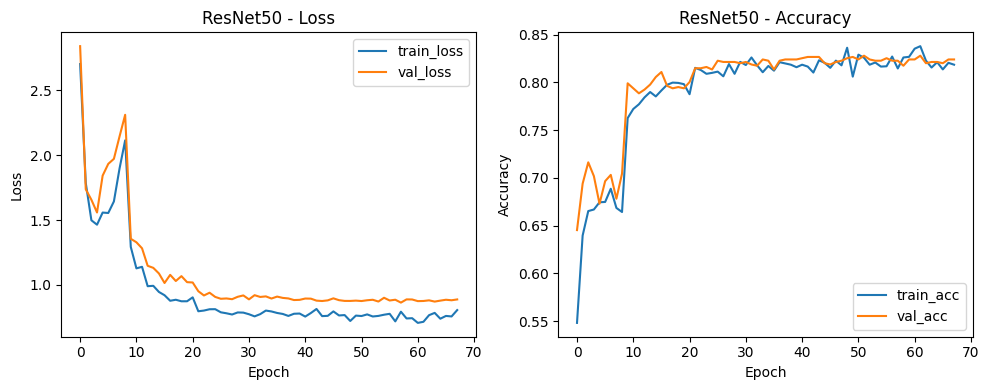


Train Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.84      0.96      0.90       295
      2-Food Organics       0.92      0.98      0.95       263
              3-Glass       0.87      0.94      0.90       269
              4-Metal       0.85      0.95      0.90       505
5-Miscellaneous Trash       0.94      0.74      0.83       317
              6-Paper       0.92      0.91      0.91       320
            7-Plastic       0.94      0.77      0.85       589
      8-Textile Trash       0.85      0.98      0.91       203
         9-Vegetation       0.94      0.99      0.97       279

             accuracy                           0.90      3040
            macro avg       0.90      0.91      0.90      3040
         weighted avg       0.90      0.90      0.89      3040


Validation Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.77      0.81      0

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],   label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('ResNet50 - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],   label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('ResNet50 - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

# --- Compute metrics on train, val, and test ---
def compute_metrics(X, y, split_name):
    y_prob = model.predict(X, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y, axis=1)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec  = recall_score( y_true, y_pred, average='weighted', zero_division=0)
    f1   = f1_score(   y_true, y_pred, average='weighted', zero_division=0)
    acc  = accuracy_score(y_true, y_pred)
    auc  = roc_auc_score(y, y_prob, multi_class='ovr', average='weighted')
    print(f"\n{split_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    return {'Precision':prec, 'Recall':rec, 'F1':f1, 'Accuracy':acc, 'AUC':auc}

resnet50_train = compute_metrics(X_train, y_train, 'Train')
resnet50_val   = compute_metrics(X_val,   y_val,   'Validation')
resnet50_test  = compute_metrics(X_test,  y_test,  'Test')

df = pd.DataFrame([resnet50_train, resnet50_val, resnet50_test], index=['Train','Val','Test'])
print("\nSummary metrics for ResNet50:")
print(df)


## ResNet100

In [7]:
base = ResNet101(
    weights='imagenet', include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)
base.trainable = False
inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs, name='ResNet100')
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "ResNet100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,193,225 (164.77 MB)

 Trainable params: 530,953 (2.03 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [8]:
rlrp = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1,
    patience=5, min_lr=1e-6, verbose=1
)

class DelayedEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.es = EarlyStopping(**kwargs)
        self.es_active = False
    
    def on_train_begin(self, logs=None):
        self.es.on_train_begin(logs)
    
    def set_model(self, model):
        self.es.set_model(model)
        super().set_model(model)
    
    def on_epoch_end(self, epoch, logs=None):
        self.es.on_epoch_end(epoch, logs)
        
        if epoch + 1 >= self.min_epochs:
            self.es_active = True
            # Check if we should stop training
            if self.es.stopped_epoch > 0:
                self.model.stop_training = True
        else:
            self.model.stop_training = False
    
    def on_train_end(self, logs=None):
        self.es.on_train_end(logs)

es = DelayedEarlyStopping(
    min_epochs=50,
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[rlrp, es],
    verbose=2
)

Epoch 1/100
608/608 - 47s - 78ms/step - accuracy: 0.5516 - loss: 2.6120 - val_accuracy: 0.6859 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 2/100
608/608 - 39s - 64ms/step - accuracy: 0.6556 - loss: 1.7054 - val_accuracy: 0.7109 - val_loss: 1.6021 - learning_rate: 0.0010
Epoch 3/100
608/608 - 40s - 66ms/step - accuracy: 0.6632 - loss: 1.5399 - val_accuracy: 0.7188 - val_loss: 1.5887 - learning_rate: 0.0010
Epoch 4/100
608/608 - 40s - 65ms/step - accuracy: 0.6727 - loss: 1.5505 - val_accuracy: 0.7188 - val_loss: 1.6005 - learning_rate: 0.0010
Epoch 5/100
608/608 - 39s - 64ms/step - accuracy: 0.6780 - loss: 1.5827 - val_accuracy: 0.7280 - val_loss: 1.6336 - learning_rate: 0.0010
Epoch 6/100
608/608 - 38s - 63ms/step - accuracy: 0.6882 - loss: 1.5589 - val_accuracy: 0.6846 - val_loss: 2.0606 - learning_rate: 0.0010
Epoch 7/100
608/608 - 38s - 62ms/step - accuracy: 0.6724 - loss: 1.7557 - val_accuracy: 0.7214 - val_loss: 1.9021 - learning_rate: 0.0010
Epoch 8/100

Epoch 8: ReduceLROnPl

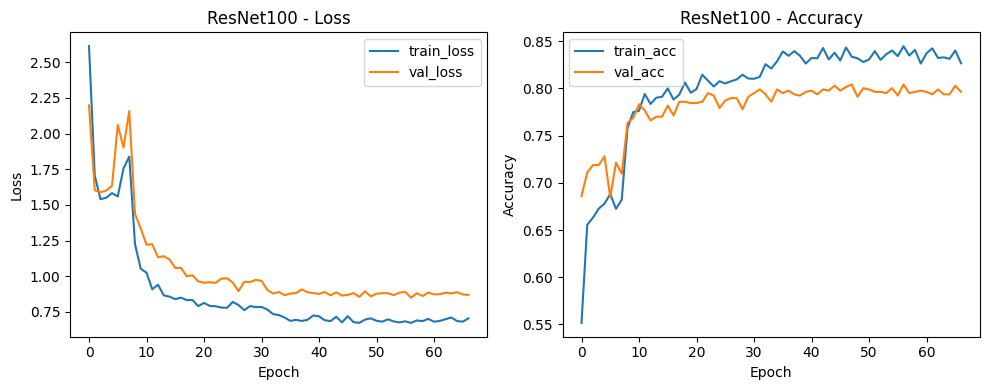


Train Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.86      0.95      0.90       295
      2-Food Organics       0.95      0.96      0.96       263
              3-Glass       0.90      0.93      0.91       269
              4-Metal       0.84      0.97      0.90       505
5-Miscellaneous Trash       0.96      0.74      0.84       317
              6-Paper       0.94      0.93      0.93       320
            7-Plastic       0.94      0.81      0.87       589
      8-Textile Trash       0.83      0.96      0.89       203
         9-Vegetation       0.94      0.99      0.97       279

             accuracy                           0.90      3040
            macro avg       0.91      0.92      0.91      3040
         weighted avg       0.91      0.90      0.90      3040


Validation Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.67      0.84      0

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('ResNet100 - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('ResNet100 - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

resnet100_train = compute_metrics(X_train, y_train, 'Train')
resnet100_val   = compute_metrics(X_val,   y_val,   'Validation')
resnet100_test  = compute_metrics(X_test,  y_test,  'Test')
df = pd.DataFrame([resnet100_train, resnet100_val, resnet100_test], index=['Train','Val','Test'])
print("\nSummary metrics for ResNet100:")
print(df)

### EfficientNetB0

In [10]:
base = EfficientNetB0(
    weights='imagenet', include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)
base.trainable = False
inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs, name='EfficientNetB0')
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,940 (16.73 MB)

 Trainable params: 332,809 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [11]:
rlrp = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1,
    patience=5, min_lr=1e-6, verbose=1
)

class DelayedEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.es = EarlyStopping(**kwargs)
        self.es_active = False
    
    def on_train_begin(self, logs=None):
        # Initialize the early stopping callback
        self.es.on_train_begin(logs)
    
    def set_model(self, model):
        self.es.set_model(model)
        super().set_model(model)
    
    def on_epoch_end(self, epoch, logs=None):
        # Always call on_epoch_end to update internal state
        self.es.on_epoch_end(epoch, logs)
        
        # But only consider stopping after min_epochs
        if epoch + 1 >= self.min_epochs:
            self.es_active = True
            # Check if we should stop training
            if self.es.stopped_epoch > 0:
                self.model.stop_training = True
        else:
            # Override any stop signal before min_epochs
            self.model.stop_training = False
    
    def on_train_end(self, logs=None):
        self.es.on_train_end(logs)

es = DelayedEarlyStopping(
    min_epochs=50,
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[rlrp, es],
    verbose=2
)

Epoch 1/100
608/608 - 29s - 47ms/step - accuracy: 0.4806 - loss: 2.4292 - val_accuracy: 0.6649 - val_loss: 1.6903 - learning_rate: 0.0010
Epoch 2/100
608/608 - 19s - 31ms/step - accuracy: 0.5615 - loss: 1.7244 - val_accuracy: 0.6294 - val_loss: 1.7689 - learning_rate: 0.0010
Epoch 3/100
608/608 - 19s - 32ms/step - accuracy: 0.5770 - loss: 1.5209 - val_accuracy: 0.6242 - val_loss: 1.6369 - learning_rate: 0.0010
Epoch 4/100
608/608 - 20s - 33ms/step - accuracy: 0.5931 - loss: 1.4277 - val_accuracy: 0.6413 - val_loss: 1.5612 - learning_rate: 0.0010
Epoch 5/100
608/608 - 20s - 32ms/step - accuracy: 0.5964 - loss: 1.4228 - val_accuracy: 0.6859 - val_loss: 1.2282 - learning_rate: 0.0010
Epoch 6/100
608/608 - 19s - 32ms/step - accuracy: 0.6010 - loss: 1.4579 - val_accuracy: 0.6124 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 7/100
608/608 - 20s - 33ms/step - accuracy: 0.5957 - loss: 1.4644 - val_accuracy: 0.6689 - val_loss: 1.4667 - learning_rate: 0.0010
Epoch 8/100
608/608 - 20s - 32ms/s

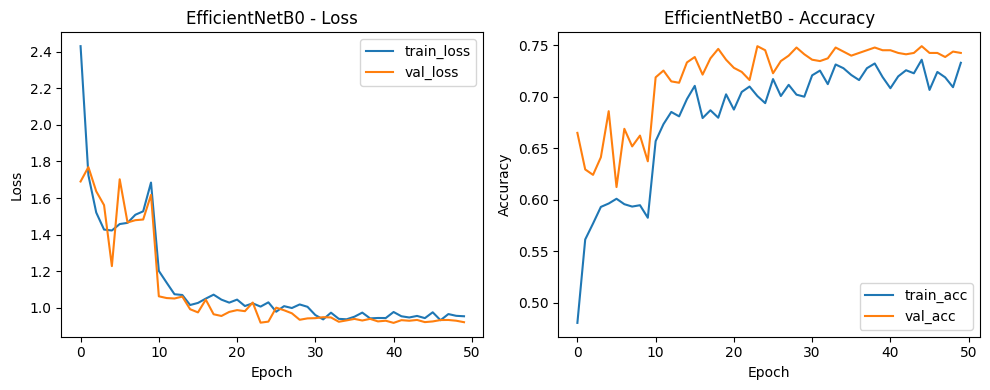


Train Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.66      0.90      0.76       295
      2-Food Organics       0.77      0.92      0.84       263
              3-Glass       0.87      0.88      0.87       269
              4-Metal       0.79      0.86      0.82       505
5-Miscellaneous Trash       0.86      0.57      0.69       317
              6-Paper       0.89      0.82      0.85       320
            7-Plastic       0.91      0.70      0.79       589
      8-Textile Trash       0.78      0.85      0.81       203
         9-Vegetation       0.84      0.96      0.90       279

             accuracy                           0.82      3040
            macro avg       0.82      0.83      0.82      3040
         weighted avg       0.83      0.82      0.81      3040


Validation Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.61      0.89      0

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('EfficientNetB0 - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('EfficientNetB0 - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

EfficientNetB0_train = compute_metrics(X_train, y_train, 'Train')
EfficientNetB0_val   = compute_metrics(X_val,   y_val,   'Validation')
EfficientNetB0_test  = compute_metrics(X_test,  y_test,  'Test')
df = pd.DataFrame([EfficientNetB0_train, EfficientNetB0_val, EfficientNetB0_test], index=['Train','Val','Test'])
print("\nSummary metrics for ResNet100:")
print(df)


### VGG16

In [13]:
base = VGG16(
    weights='imagenet', include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)
base.trainable = False
inputs = Input(shape=(*IMAGE_SIZE, 3))
x = base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs, name='VGG16')
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,377 (56.65 MB)

 Trainable params: 134,665 (526.04 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [14]:
rlrp = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1,
    patience=5, min_lr=1e-6, verbose=1
)

class DelayedEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.es = EarlyStopping(**kwargs)
        self.es_active = False
    
    def on_train_begin(self, logs=None):
        self.es.on_train_begin(logs)
    
    def set_model(self, model):
        self.es.set_model(model)
        super().set_model(model)
    
    def on_epoch_end(self, epoch, logs=None):
        self.es.on_epoch_end(epoch, logs)
        
        if epoch + 1 >= self.min_epochs:
            self.es_active = True
            if self.es.stopped_epoch > 0:
                self.model.stop_training = True
        else:
            self.model.stop_training = False
    
    def on_train_end(self, logs=None):
        self.es.on_train_end(logs)

es = DelayedEarlyStopping(
    min_epochs=50,
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[rlrp, es],
    verbose=2
)

Epoch 1/100
608/608 - 30s - 49ms/step - accuracy: 0.4997 - loss: 1.8140 - val_accuracy: 0.6623 - val_loss: 1.2661 - learning_rate: 0.0010
Epoch 2/100
608/608 - 29s - 47ms/step - accuracy: 0.5799 - loss: 1.3741 - val_accuracy: 0.7030 - val_loss: 1.1460 - learning_rate: 0.0010
Epoch 3/100
608/608 - 29s - 47ms/step - accuracy: 0.6187 - loss: 1.2832 - val_accuracy: 0.6965 - val_loss: 1.1329 - learning_rate: 0.0010
Epoch 4/100
608/608 - 29s - 47ms/step - accuracy: 0.6043 - loss: 1.2917 - val_accuracy: 0.7004 - val_loss: 1.0524 - learning_rate: 0.0010
Epoch 5/100
608/608 - 29s - 47ms/step - accuracy: 0.5901 - loss: 1.3277 - val_accuracy: 0.6636 - val_loss: 1.2694 - learning_rate: 0.0010
Epoch 6/100
608/608 - 29s - 47ms/step - accuracy: 0.5908 - loss: 1.3782 - val_accuracy: 0.6583 - val_loss: 1.2462 - learning_rate: 0.0010
Epoch 7/100
608/608 - 29s - 47ms/step - accuracy: 0.5931 - loss: 1.3903 - val_accuracy: 0.6702 - val_loss: 1.2567 - learning_rate: 0.0010
Epoch 8/100
608/608 - 28s - 47ms/s

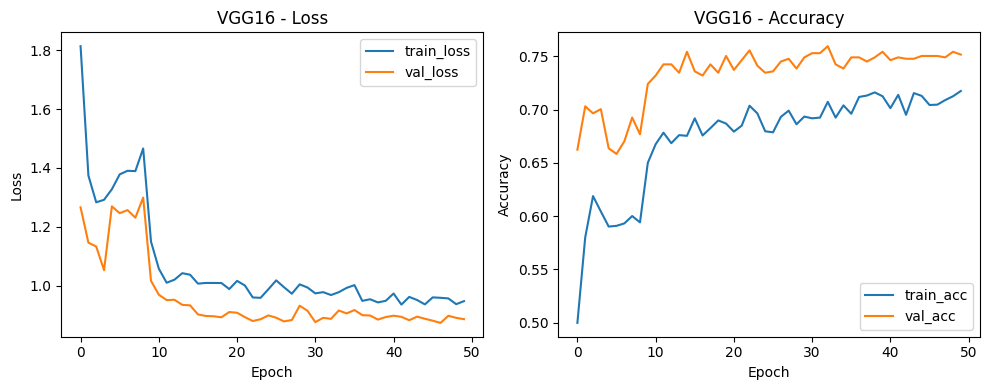


Train Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.84      0.81      0.82       295
      2-Food Organics       0.87      0.91      0.89       263
              3-Glass       0.79      0.88      0.83       269
              4-Metal       0.81      0.85      0.83       505
5-Miscellaneous Trash       0.78      0.64      0.70       317
              6-Paper       0.85      0.86      0.85       320
            7-Plastic       0.82      0.76      0.79       589
      8-Textile Trash       0.78      0.84      0.81       203
         9-Vegetation       0.89      0.96      0.93       279

             accuracy                           0.82      3040
            macro avg       0.83      0.83      0.83      3040
         weighted avg       0.82      0.82      0.82      3040


Validation Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       0.72      0.73      0

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

VGG16_train = compute_metrics(X_train, y_train, 'Train')
VGG16_val   = compute_metrics(X_val,   y_val,   'Validation')
VGG16_test  = compute_metrics(X_test,  y_test,  'Test')
df = pd.DataFrame([VGG16_train, VGG16_val, VGG16_test], index=['Train','Val','Test'])
print("\nSummary metrics for VGG16:")
print(df)

### Comparision

In [16]:
df = pd.DataFrame([resnet50_test, resnet100_test, EfficientNetB0_test, VGG16_test], index=['ResNet50','ResNet100','EfficientNetB0', 'VGG16'])
print("\nComparision of all models:")
print(df)


Comparision of all models:
                Precision    Recall        F1  Accuracy       AUC
ResNet50         0.816154  0.809674  0.802689  0.809674  0.976895
ResNet100        0.824273  0.815983  0.811563  0.815983  0.977403
EfficientNetB0   0.745212  0.733964  0.728633  0.733964  0.959713
VGG16            0.757355  0.759201  0.755550  0.759201  0.960051


#### ResNet100 has the highest Precision, Recall, F1, Accuracy, and AUC. So ResNet100 is the best performer, although ResNet50 performance comes very close to it. VGG16 and EfficientNetB0 trail by slightly larger gap.